In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as s

In [2]:
from sklearn.linear_model import LinearRegression

def linRegressionAddInsideTemperature(df):
    linReg = LinearRegression()
    x = df[['T-outside','H-outside','T-inside']]
    noNan = x[x['T-inside'].notnull()].drop(columns='T-inside')
    noNanTinside = x[x['T-inside'].notnull()]['T-inside']
    linReg.fit(noNan,noNanTinside)
    nanT = x[x['T-inside'].isnull()].drop(columns='T-inside')
    result = linReg.predict(nanT)
    df['T-inside'][df['T-inside'].isnull()] = result
    return df

def linRegressionAddInsideHumidity(df):
    linReg = LinearRegression()
    x = df[['T-outside','H-outside','H-inside']]
    noNan = x[x['H-inside'].notnull()].drop(columns='H-inside')
    noNanTinside = x[x['H-inside'].notnull()]['H-inside']
    linReg.fit(noNan,noNanTinside)
    nanT = x[x['H-inside'].isnull()].drop(columns='H-inside')
    result = linReg.predict(nanT)
    df['H-inside'][df['H-inside'].isnull()] = result
    return df

In [3]:
def loadDataset(resampleParam):
    #load temperature and humidity data from outside
    outDf = pd.read_csv("./data/data.csv", delimiter = ";")
    outDf = outDf.rename(columns={'Tim': "Time", "Temperature": "T-outside", "Humidity": "H-outside"})
    outDf.index = pd.to_datetime(outDf['Time'], format='%d.%m.%Y %H:%M:%S' )
    outDf = outDf.drop(columns=['Time'])
    
    #load consumption data 
    consumptionDf = pd.read_csv("./data/spotreba.csv",delimiter = ";")
    consumptionDf = consumptionDf.rename(columns={'Tim': "Time", "delta kWh": "KWH"})
    consumptionDf.index = pd.to_datetime(consumptionDf['Time'], format='%d.%m.%Y %H:%M' )
    consumptionDf = consumptionDf.drop(columns=['Time'])
    
    #load temperature nad humidity data from inside
    inDf = pd.read_csv("./data/serverovna.csv",delimiter = ";")
    inDf = inDf.rename(columns={'Tim': "Time", "Temperature": "T-inside", "Humidity": "H-inside"})
    inDf.index = pd.to_datetime(inDf['Time'], format='%d.%m.%Y %H:%M:%S' )
    inDf = inDf.drop(columns=['Time'])
    
    #resample all data by input parameter
    outDfResampled = outDf.resample(resampleParam).mean()
    consumptionDfResampled = consumptionDf.resample(resampleParam).sum()
    inDfResampled = inDf.resample(resampleParam).mean()
    
    #join data
    df = outDfResampled.join(consumptionDfResampled,how="inner")
    df = df.dropna()
    df = df.join(inDfResampled,how="left")
    
    #fill nan from inside measurement by linear regression
    df = linRegressionAddInsideTemperature(df)
    df = linRegressionAddInsideHumidity(df)
       
    return df

In [4]:
df = loadDataset('H')

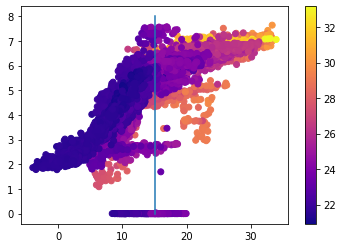

In [5]:
plt.scatter(df['T-outside'],df['KWH'], c=df['T-inside'],cmap='plasma')
plt.plot([15,15],[0,8])
plt.colorbar()
plt.show()

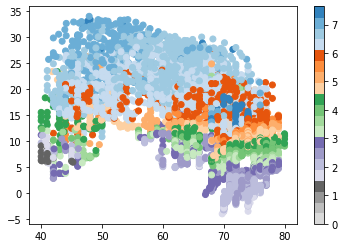

In [6]:
plt.scatter(df['H-outside'],df['T-outside'], c=df['KWH'],cmap='tab20c_r')
plt.colorbar()

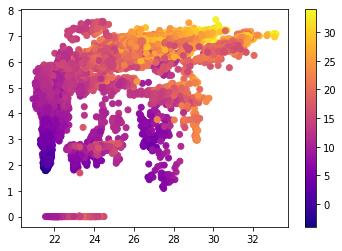

In [7]:
plt.scatter(df['T-inside'],df['KWH'], c=df['T-outside'],cmap='plasma')
plt.colorbar()
plt.show()

C:\Users\William.Brach\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


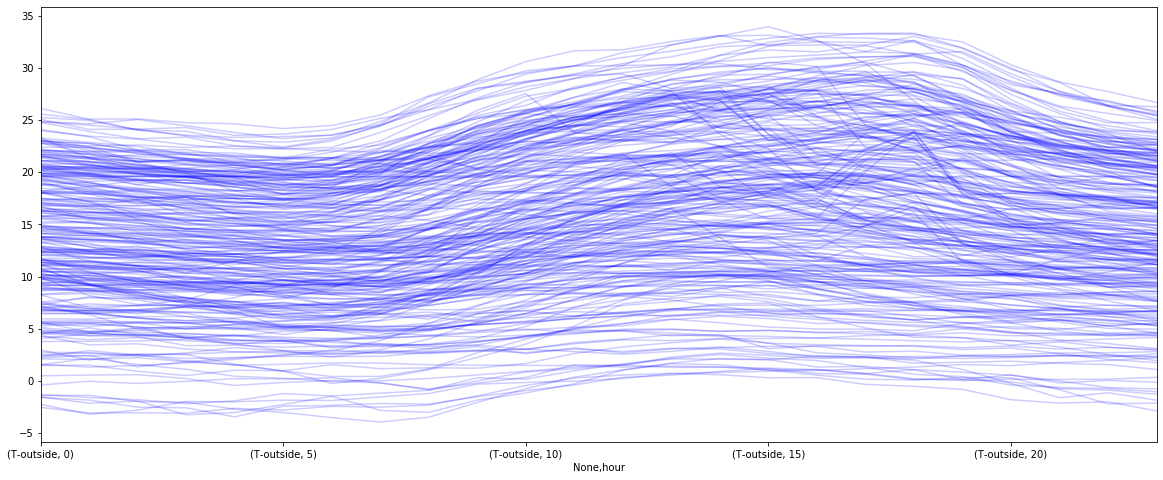

In [8]:
df_uci_hourly = df[['T-outside']]
df_uci_hourly['hour'] = df_uci_hourly.index.hour
df_uci_hourly.index = df_uci_hourly.index.date

df_uci_pivot = df_uci_hourly.pivot(columns='hour')
df_uci_pivot = df_uci_pivot.dropna()
df_uci_pivot.T.plot(figsize=(20,8), legend=False, color='blue', alpha=0.2)

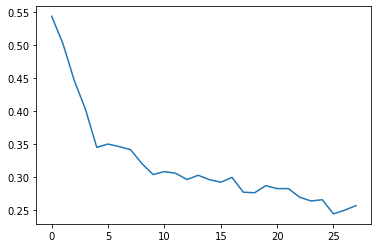

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
sillhoute_scores = []
n_cluster_list = np.arange(2,30).astype(int)

X = df_uci_pivot.values.copy()
    
# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))
plt.plot(sillhoute_scores)

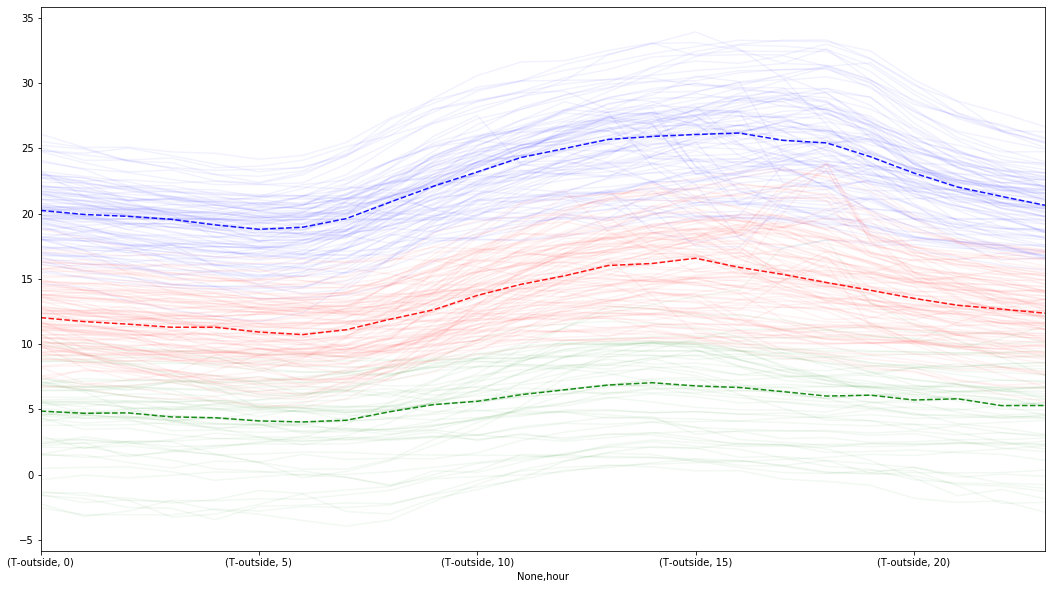

In [10]:
kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
df_uci_pivot = df_uci_pivot.set_index(cluster_found_sr, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.05, color=color, label= f'Cluster {cluster}'
        )
    df_uci_pivot.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )


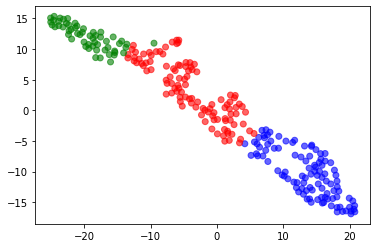

In [11]:
from sklearn.manifold import TSNE
import matplotlib.colors

tsne = TSNE()
results_tsne = tsne.fit_transform(X)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=df_uci_pivot.index.get_level_values('cluster'),
    cmap=cmap, 
    alpha=0.6, 
    )

C:\Users\William.Brach\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


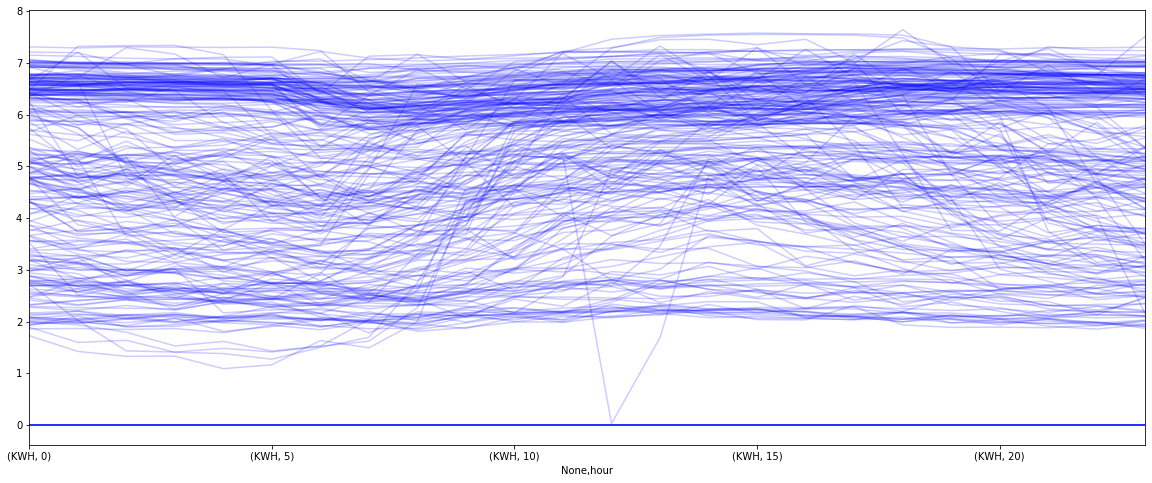

In [12]:
df_uci_hourly = df[['KWH']]
df_uci_hourly['hour'] = df_uci_hourly.index.hour
df_uci_hourly.index = df_uci_hourly.index.date

df_uci_pivot = df_uci_hourly.pivot(columns='hour')
df_uci_pivot = df_uci_pivot.dropna()
df_uci_pivot.T.plot(figsize=(20,8), legend=False, color='blue', alpha=0.2)

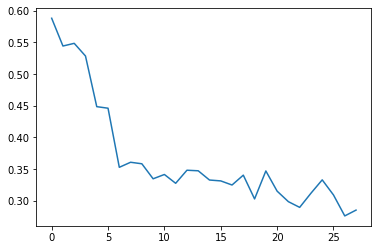

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
sillhoute_scores = []
n_cluster_list = np.arange(2,30).astype(int)

X = df_uci_pivot.values.copy()
    
# Very important to scale!
sc = MinMaxScaler()
X = sc.fit_transform(X)

for n_cluster in n_cluster_list:    
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))
plt.plot(sillhoute_scores)

In [ ]:
kmeans = KMeans(n_clusters=2)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
df_uci_pivot = df_uci_pivot.set_index(cluster_found_sr, append=True )

fig, ax= plt.subplots(1,1, figsize=(18,10))
color_list = ['blue','red','green']
cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())

for cluster, color in zip(cluster_values, color_list):
    df_uci_pivot.xs(cluster, level=1).T.plot(
        ax=ax, legend=False, alpha=0.05, color=color, label= f'Cluster {cluster}'
        )
    df_uci_pivot.xs(cluster, level=1).median().plot(
        ax=ax, color=color, alpha=0.9, ls='--'
    )


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.colors

tsne = TSNE()
results_tsne = tsne.fit_transform(X)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=df_uci_pivot.index.get_level_values('cluster'),
    cmap=cmap, 
    alpha=0.6, 
    )